In [10]:
import time
import torch
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kokoro import KPipeline
from gtts import gTTS

In [11]:
# **Function to test latency for Kokoro TTS model**
def test_kokoro_tts(text, iterations, lang_code='a', repo_id='hexgrad/Kokoro-82M', device='cuda'):
    kokoro_times = []
    print("Testing Kokoro TTS model...")
    print(device)
    pipeline = KPipeline(lang_code=lang_code, repo_id=repo_id, device=device)
    for run in range(iterations):
        start_time = time.time()

        generator = pipeline(text, voice='af_heart')
        for i, (gs, ps, audio) in enumerate(generator):
            print(f"Run {run + 1} - Kokoro Output {i}: {gs}, {ps}")
            sf.write(f'kokoro_output_{run}_{i}.wav', audio, 24000)

        end_time = time.time()
        run_time = end_time - start_time
        kokoro_times.append(run_time)
        print(f"Run {run + 1} - Kokoro Execution Time: {run_time:.2f} seconds\n")

    return kokoro_times

In [12]:

# **Function to test latency for gTTS**
def test_gtts(text, iterations):
    gtts_times = []
    print("Testing gTTS...")
    for run in range(iterations):
        start_time = time.time()
        myobj = gTTS(text=text, lang='en', slow=False)
        myobj.save(f"gtts_output_{run}.wav")
        end_time = time.time()
        run_time = end_time - start_time
        gtts_times.append(run_time)
        print(f"Run {run + 1} - gTTS Execution Time: {run_time:.2f} seconds\n")

    return gtts_times

In [13]:
# **Input Text and number of iterations to be tested with all models**
text = '''
Warning! There is a person (quite close) directly ahead and 2 persons (quite close) to the left.
'''

In [14]:
# Run latency tests and store results
iterations = 5
kokoro_latencies = test_kokoro_tts(text, iterations)

Testing Kokoro TTS model...
cuda


d:\miniconda3\envs\video_to_audio\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
d:\miniconda3\envs\video_to_audio\lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Run 1 - Kokoro Output 0: Warning! There is a person (quite close) directly ahead and 2 persons (quite close) to the left., wˈɔɹnɪŋ! ðˌɛɹ ɪz ɐ pˈɜɹsᵊn (kwˈIt klˈOs) dəɹˈɛktli əhˈɛd ænd tˈu pˈɜɹsᵊnz (kwˈIt klˈOs) tə ðə lˈɛft.
Run 1 - Kokoro Execution Time: 0.92 seconds

Run 2 - Kokoro Output 0: Warning! There is a person (quite close) directly ahead and 2 persons (quite close) to the left., wˈɔɹnɪŋ! ðˌɛɹ ɪz ɐ pˈɜɹsᵊn (kwˈIt klˈOs) dəɹˈɛktli əhˈɛd ænd tˈu pˈɜɹsᵊnz (kwˈIt klˈOs) tə ðə lˈɛft.
Run 2 - Kokoro Execution Time: 0.28 seconds

Run 3 - Kokoro Output 0: Warning! There is a person (quite close) directly ahead and 2 persons (quite close) to the left., wˈɔɹnɪŋ! ðˌɛɹ ɪz ɐ pˈɜɹsᵊn (kwˈIt klˈOs) dəɹˈɛktli əhˈɛd ænd tˈu pˈɜɹsᵊnz (kwˈIt klˈOs) tə ðə lˈɛft.
Run 3 - Kokoro Execution Time: 0.27 seconds

Run 4 - Kokoro Output 0: Warning! There is a person (quite close) directly ahead and 2 persons (quite close) to the left., wˈɔɹnɪŋ! ðˌɛɹ ɪz ɐ pˈɜɹsᵊn (kwˈIt klˈOs) dəɹˈɛktli əhˈɛd ænd tˈu pˈɜɹs

In [15]:
gtts_latencies = test_gtts(text, iterations)

Testing gTTS...
Run 1 - gTTS Execution Time: 0.55 seconds

Run 2 - gTTS Execution Time: 0.62 seconds

Run 3 - gTTS Execution Time: 0.73 seconds

Run 4 - gTTS Execution Time: 0.53 seconds

Run 5 - gTTS Execution Time: 0.73 seconds



In [16]:
def plot_tts_latency(df_local, df_api, kokoro_latencies, gtts_latencies):
    local_tts = df_local['text_to_speech']
    api_tts = df_api['text_to_speech']

    # Calculate min, max, and average for each TTS system
    stats = {
        'Local Host OpenAI': [local_tts.min(), local_tts.max(), local_tts.mean()],
        'API OpenAI': [api_tts.min(), api_tts.max(), api_tts.mean()],
        'Kokoro TTS': [min(kokoro_latencies), max(kokoro_latencies), np.mean(kokoro_latencies)],
        'gTTS': [min(gtts_latencies), max(gtts_latencies), np.mean(gtts_latencies)]
    }

    labels = list(stats.keys())
    min_values = [val[0] for val in stats.values()]
    max_values = [val[1] for val in stats.values()]
    avg_values = [val[2] for val in stats.values()]

    width = 0.2  # Bar width
    x = np.arange(len(labels))

    plt.figure(figsize=(12, 6))

    # Plot min, max, and average as grouped bars
    plt.bar(x - width, min_values, width=width, label='Min Latency', color='skyblue')
    plt.bar(x, avg_values, width=width, label='Average Latency', color='orange')
    plt.bar(x + width, max_values, width=width, label='Max Latency', color='lightgreen')

    # Labeling
    plt.xlabel("TTS Systems")
    plt.ylabel("Execution Time (seconds)")
    plt.title("Text-to-Speech Latency Comparison")
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Annotate bars with latency values
    for i in range(len(labels)):
        plt.text(x[i] - width, min_values[i] + 0.05, f'{min_values[i]:.2f}s', ha='center', fontsize=9)
        plt.text(x[i], avg_values[i] + 0.05, f'{avg_values[i]:.2f}s', ha='center', fontsize=9)
        plt.text(x[i] + width, max_values[i] + 0.05, f'{max_values[i]:.2f}s', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

In [17]:
df_local = pd.read_csv(r'D:\My Hoa\work\VideoToAudioGuide\outputs\reports\test1_20250319_152519\execution_time_20250320_163533.csv')
df_api = pd.read_csv(r"D:\My Hoa\work\VideoToAudioGuide\outputs\reports\test1_20250317_170310\execution_time_20250320_164849.csv")

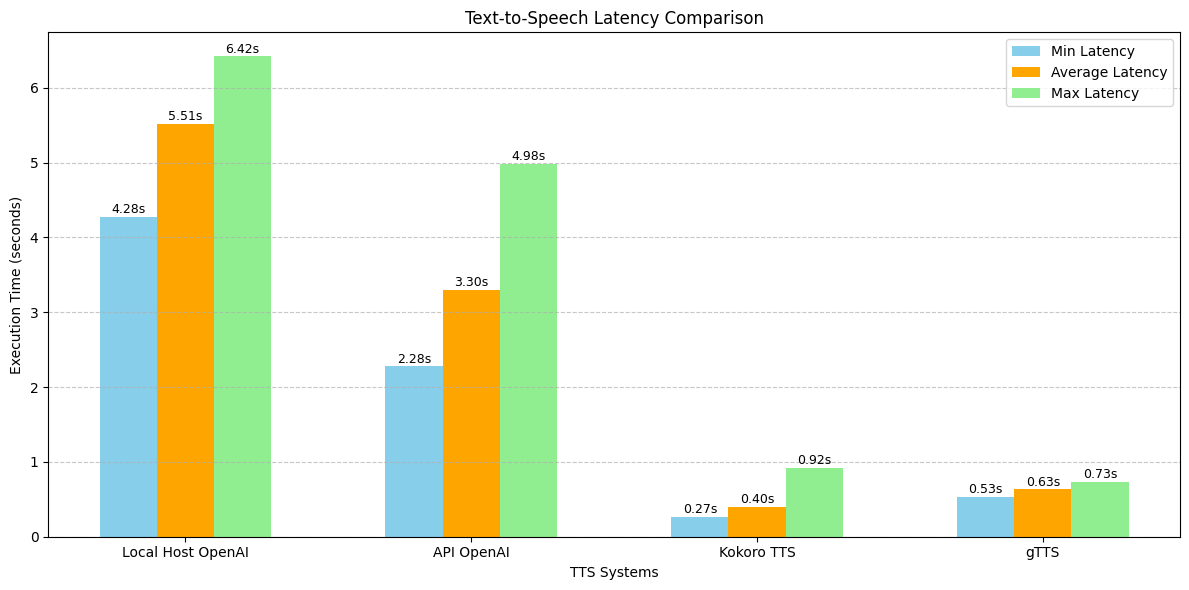

In [18]:
plot_tts_latency(df_local, df_api, kokoro_latencies, gtts_latencies)